In [1]:
%cd "C:/app"


C:\app


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')


sns.set(rc={'figure.figsize':(10,5)})
sns.set_theme()
sns.set_style('whitegrid')

In [4]:
# load data
from pathlib import Path
from sklearn.preprocessing import scale


data = pd.read_csv("./data/trees/features_targets.csv", index_col="Timestamp", parse_dates=["Timestamp"])

excluded_cols = ['Open',
 'High',
 'Low',
 'Close',
 'Symbol']

all_cols = [c for c in data.columns if c not in excluded_cols ]
data = data[all_cols]

data.loc[:, data.columns] = scale(data)

features_cols = data.columns[data.columns.str.contains("TARGET") == False]
features = data[features_cols]
features.describe()

target_col = "TARGET_LOGRET_5"
targets = data[[target_col]]
targets.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 13906 entries, 2018-01-26 15:00:00 to 2019-12-31 15:30:00
Data columns (total 1 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   TARGET_LOGRET_5  13906 non-null  float64
dtypes: float64(1)
memory usage: 217.3 KB


<Axes: ylabel='Density'>

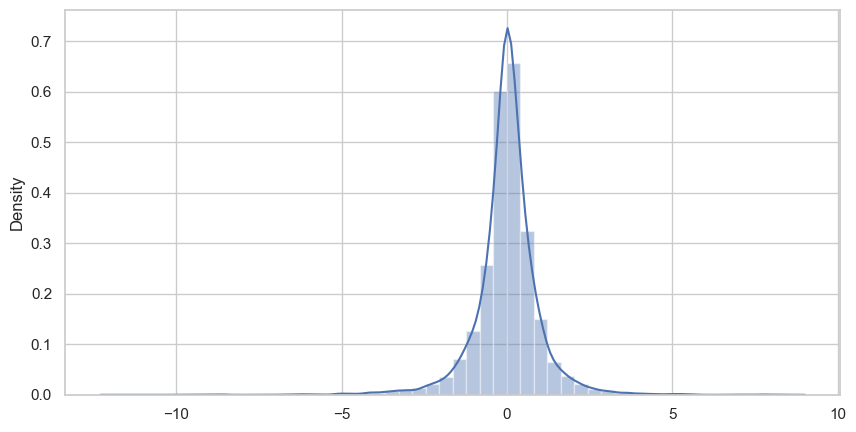

In [5]:
# Explore data
sns.distplot(targets)

In [6]:
# select two features for the rest
selected_features = ["STDEV_100", "SMA_500"]
X_2 = features[selected_features]
y_2 = targets

**Simple Classification Tree with Time Series Data**

In [7]:
y_binary = (y_2 > 0).astype(int)
y_binary.value_counts()

TARGET_LOGRET_5
1                  7207
0                  6699
Name: count, dtype: int64

**Configure Tree**

In [8]:
from sklearn.tree import DecisionTreeClassifier, export_graphviz
import graphviz

clf_tree_t2 = DecisionTreeClassifier(criterion='gini', # or entropy
                                     splitter='best',
                                     max_depth=5,
                                     min_samples_split=1000,
                                     min_samples_leaf=1,
                                     min_weight_fraction_leaf=0.0,
                                     max_features=None,
                                     random_state=42,
                                     max_leaf_nodes=None,
                                     class_weight=None)

In [9]:
clf_tree_t2.fit(X=X_2, y=y_binary)

DecisionTreeClassifier(max_depth=5, min_samples_split=1000, random_state=42)

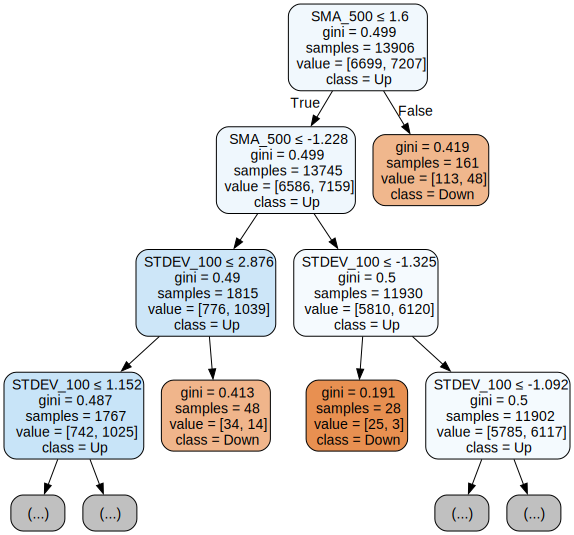

In [10]:
dot_data = export_graphviz(clf_tree_t2,
                           feature_names=X_2.columns,
                           class_names=['Down', 'Up'],
                           max_depth=3,
                           filled=True,
                           rounded=True,
                           special_characters=True)

graphviz.Source(dot_data)

**Classification with all features**

In [11]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(features, y_binary, test_size=0.2, random_state=42)

clf = DecisionTreeClassifier(criterion='entropy',
                             max_depth=5,
                             random_state=42)
clf.fit(X=X_train, y=y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=5, random_state=42)

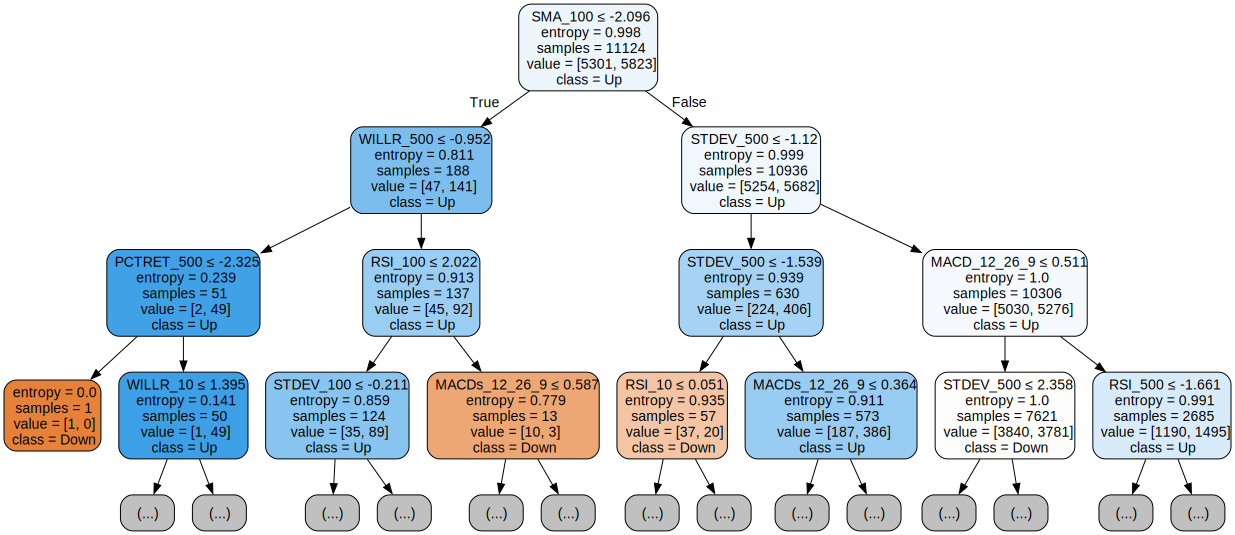

In [12]:
dot_data = export_graphviz(clf,
                           feature_names=X_train.columns,
                           class_names=['Down', 'Up'],
                           max_depth=3,
                           filled=True,
                           rounded=True,
                           special_characters=True)

graphviz.Source(dot_data)

In [13]:
# prediction
y_score = clf.predict_proba(X=X_train)[:, 1]
y_score_labels = (y_score > 0.5).astype(int)
y_score

array([0.49161342, 0.49161342, 0.49161342, ..., 0.81395349, 0.49161342,
       0.49161342])

In [15]:
# measuring the performance of classification
import sklearn 
from sklearn.metrics import classification_report


print(sklearn.metrics.classification_report(y_train, y_score_labels))

              precision    recall  f1-score   support

           0       0.51      0.74      0.61      5301
           1       0.61      0.36      0.45      5823

    accuracy                           0.54     11124
   macro avg       0.56      0.55      0.53     11124
weighted avg       0.56      0.54      0.53     11124

